In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfk = tf.keras
tfd = tfp.distributions

import numpy as np
import matplotlib.pyplot as plt

from utils import eq_covariance,              \
                  sample_1d_datasets_from_gp

from IPython.display import HTML, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

import datetime
%load_ext tensorboard

In [2]:
x_min = -4.
x_max = 4.
num_datasets = 64
num_datapoints = 30
scale = 2e0
cov_coeff = 1e0
noise_coeff = 1e-2

x, y = sample_1d_datasets_from_gp(x_min=x_min,
                                  x_max=x_max,
                                  num_datasets=num_datasets,
                                  num_datapoints=num_datapoints,
                                  scale=scale,
                                  cov_coeff=cov_coeff,
                                  noise_coeff=noise_coeff)

x = tf.cast(x[..., None], dtype=tf.float32)
y = tf.cast(y[..., None], dtype=tf.float32)

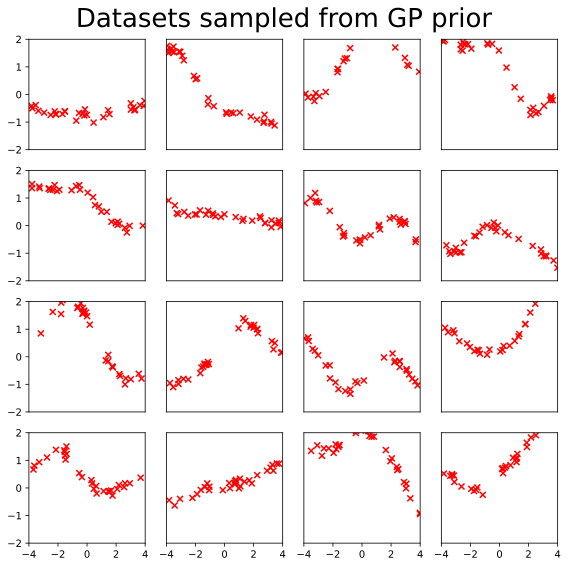

In [3]:
plt.figure(figsize=(8, 8))

for i in range(16):
    
    plt.subplot(4, 4, i + 1)
    plt.scatter(x[i, :, 0], y[i, :, 0], marker='x', color='red')
    
    plt.xlim([-4, 4])
    plt.ylim([-2, 2])
    
    plt.xticks(np.linspace(-4, 4, 5))
    plt.yticks(np.linspace(-2, 2, 5))
    
    if i % 4 != 0:
        plt.yticks([])
        
    if i <= 11 != 0:
        plt.xticks([])

plt.suptitle('Datasets sampled from GP prior', fontsize=26)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## The Neural Process model

### Loss functions

<div class='lemma'>

**Result (Evidence Lower Bound)** For any distribtutions $p$ and $q$, the following inequality holds
    
$$\begin{align}
\log p(\mathbf{Y} | \mathbf{X}) \geq \mathbb{E}_{q(\mathbf{Z} | \mathbf{X}, \mathbf{Y})} \left[ \log p(\mathbf{Y} | \mathbf{Z}, \mathbf{X}) + \log \frac{p(\mathbf{Z})}{q(\mathbf{Z} | \mathbf{X}, \mathbf{Y})} \right],
\end{align}$$
    
assuming that $p(\mathbf{Z} | \mathbf{X}) = p(\mathbf{Z})$. The quantity on the right is called the Evience Lower Bound or ELBO.
    
</div>
<br>

<details class='proof'>
<summary> Derivation: Evidence Lower Bound </summary>
   
Starting from the marginal likelihood $\log p(\mathbf{Y} | \mathbf{X})$ and subtracting from it the KL-divergence between $q(\mathbf{Z} | \mathbf{X}, \mathbf{Y})$ and $p(\mathbf{Z} | \mathbf{X}, \mathbf{Y})$ we have
    
$$\begin{align}
\log p(\mathbf{Y} | \mathbf{X}) \geq \log p(\mathbf{Y} | \mathbf{X}) + \mathbb{E}_{q(\mathbf{Z} | \mathbf{X}, \mathbf{Y})}\left[ \log \frac{p(\mathbf{Z} | \mathbf{X}, \mathbf{Y})}{q(\mathbf{Z} | \mathbf{X}, \mathbf{Y})} \right]
\end{align}$$
   
where the inequality holds because the KL divergence of any two distriubtions is always non-negative. Since the likelihood is independent of $\mathbf{Z}$ we can take it inside the integral
    
$$\begin{align}
\log p(\mathbf{Y} | \mathbf{X}) \geq \mathbb{E}_{q(\mathbf{Z} | \mathbf{X}, \mathbf{Y})}\left[ \log p(\mathbf{Y} | \mathbf{X}) + \log \frac{p(\mathbf{Z} | \mathbf{X}, \mathbf{Y})}{q(\mathbf{Z} | \mathbf{X}, \mathbf{Y})} \right] = \mathbb{E}_{q(\mathbf{Z} | \mathbf{X}, \mathbf{Y})}\left[ \log \frac{p(\mathbf{Y}, \mathbf{Z} | \mathbf{X})}{q(\mathbf{Z} | \mathbf{X}, \mathbf{Y})} \right],
\end{align}$$
    
where we have used the definition of conditional probability. Finally, with another application of conditional probability and the assumption $p(\mathbf{Z} | \mathbf{X}) = p(\mathbf{Z})$, we arrive at
    
$$\begin{align}
\log p(\mathbf{Y} | \mathbf{X}) \geq \mathbb{E}_{q(\mathbf{Z} | \mathbf{X}, \mathbf{Y})}\left[ \log p(\mathbf{Y} | \mathbf{Z}, \mathbf{X}) + \log \frac{p(\mathbf{Z})}{q(\mathbf{Z} | \mathbf{X}, \mathbf{Y})} \right].
\end{align}$$
    
</details>
<br>

For NPs, we have $\mathbf{X} = x_{1:n}$, $\mathbf{Z} = z$ and $\mathbf{Y} = y_{1:n}$ so the ELBO becomes

$$\begin{align}
\log p(y_{1:N} | x_{1:N}) \geq \mathbb{E}_{q(z | x_{1:N}, y_{1:N})} \left[ \sum_{n = 1}^N \log p(y_{n} | z, x_{n}) + \log \frac{p(z)}{q(z | x_{1:N}, y_{1:N})} \right].
\end{align}$$

where we have used the fact that $p(y_{1:n} | z, x_{1:n})$ factorises. We could train a model with this objective, using Monte Carlo samples of $z$ to estimate the above expectation. The model would consist of a neural network modelling the distribution $q$, called the encoder, and another neural network modelling the distribution $p(y | z, x)$, called the decoder.

During training, the encoder will learn to infer a distribution over the latent variable $z$, in order to summarise the statistics of the dataset $\{x_n, y_n\}_{n = 1}^N$, while the decoder will learn to make predictions about $y_n$ given new inputs $x_n$ and the latent $z$ summarising the dataset. By training the model on several datasets simultaneously, the decoder will not be able to predict $y$ from $x$ alone - because the underlying function changes with each task - and will utilise the latent parameter $z$ inferred by the encoder in order to capture infromation about the dataset at hand.

However, Garnelo et al.{cite}`garnelo2018neural` argue that at test time we are often interested in using the

In [65]:
class NeuralProcess(tf.Module):
    
    def __init__(self, encoder, decoder, name='np', **kwargs):
        
        
        super().__init__(name=name, **kwargs)
        
        self.encoder = encoder
        self.decoder = decoder
        
        
    def __call__(self, context_inputs, context_outputs, target_inputs):
        
        context_approx_post = self.encoder(context_inputs, context_outputs)
        
        context_sample = context_approx_post.sample()
        context_sample = context_sample[:, :, 0][:, None, :]
        
        output_pred_dist = self.decoder(target_inputs, context_sample)
        
        return output_pred_dist
    
    
    def loss_with_context(self,
                          inputs,
                          outputs,
                          num_dataset_samples,
                          num_latent_samples):
        
        num_datasets = x.shape[0]
        dataset_size = x.shape[1]
        
        total_loglik = 0.
        total_kl_div = 0.
        
        for i in range(num_dataset_samples):
            
            N = np.random.choice(np.arange(1, dataset_size))
            
            context_inputs = inputs[:, :N, :]
            context_outputs = outputs[:, :N, :]
            target_inputs = inputs[:, N:, :]
            target_outputs = outputs[:, N:, :]
            
            context_approx_post = self.encoder(context_inputs, context_outputs)
            full_approx_post = self.encoder(inputs, outputs)
                
            kl_div = full_approx_post.kl_divergence(context_approx_post)
            kl_div = tf.reduce_sum(kl_div)
            
            total_kl_div = total_kl_div + kl_div
            
            context_approx_post = self.encoder(context_inputs, context_outputs)

            for j in range(num_latent_samples):
        
                context_sample = full_approx_post.sample()
                context_sample = context_sample[:, :, 0][:, None, :]
                
                output_pred_dist = self.decoder(target_inputs, context_sample)

                loglik = tf.reduce_sum(output_pred_dist.log_prob(target_outputs))
                total_loglik = total_loglik + loglik
                    
            
        total_loglik = total_loglik / (num_latent_samples * num_dataset_samples * dataset_size)

        total_kl_div = total_kl_div / (num_dataset_samples * dataset_size)

        negative_elbo = - total_loglik + total_kl_div

        return negative_elbo, total_loglik, total_kl_div
    
    
    def loss_with_prior(self):
        pass

In [66]:
class FeedforwardNetwork(tf.Module):
    
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_dims,
                 nonlinearity,
                 name='feedforward_netork',
                 **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        shapes = [input_dim] + hidden_dims + [output_dim]
        shapes = [(s1, s2) for s1, s2 in zip(shapes[:-1], shapes[1:])]
        
        self.W = []
        self.b = []
        self.num_linear = len(hidden_dims) + 1
        
        with self.name_scope:
            for shape in shapes:
                
                W = tf.Variable(tf.random.normal(shape=shape) / shape[0] ** 0.5)
                b = tf.Variable(tf.random.normal(shape=shape[1:]))
                
                self.W.append(W)
                self.b.append(b)
        
        self.nonlinearity = getattr(tf.nn, nonlinearity)
        
    
    def __call__(self, tensor):
        
        for i, (W, b) in enumerate(zip(self.W, self.b)):
            
            tensor = tf.einsum('...i, ij -> ...j', tensor, W) + b[None, None, :]
            
            if i < self.num_linear - 1:
                tensor = self.nonlinearity(tensor)
        
        return tensor

In [67]:
class NeuralNetworkEncoder(tf.Module):
    
    def __init__(self, feedforward_network, latent_dist, name='neural_network_encoder', **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        self.feedforward_network = feedforward_network
        self.latent_dist = latent_dist

    
    def __call__(self, context_input, context_output):
        
        context_data = tf.concat([context_input, context_output], axis=-1)
        context = self.feedforward_network(context_data)
        
        param_tensor = tf.reduce_mean(context, axis=1)
        param_tensor = tf.reshape(param_tensor,
                                  shape=tuple(param_tensor.shape[:-1]) + (-1, 2))
        context_dist = self.latent_dist(param_tensor)
        
        return context_dist
        
        
class NeuralNetworkDecoder(tf.Module):
    
    def __init__(self, feedforward_network, likelihood, name='neural_network_decoder', **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        self.feedforward_network = feedforward_network
        self.likelihood = likelihood

    
    def __call__(self, target_inputs, context):
        
        context = tf.tile(context, multiples=(1, target_inputs.shape[1], 1))
        target_inputs_and_context = tf.concat([target_inputs, context], axis=2)
        
        param_tensor = self.feedforward_network(target_inputs_and_context)
        target_output_dist = self.likelihood(param_tensor)
        
        return target_output_dist

In [68]:
class GaussianLikelihood:
    
    def __init__(self, reparam_func, single_noise_param):
        
        self.dist = tfd.Normal
        
        if reparam_func == 'exp':
            self.reparam_func = tf.exp
            
        else:
            self.reparam_func = getattr(tf.nn, reparam_func)
        
        if single_noise_param:
            self.log_scale = tf.Variable(tf.zeros(()))
            
        self.single_noise_param = single_noise_param
        
    
    def __call__(self, param_tensor):
        
        loc, scale = self.reparametrise(param_tensor)
        dist = self.dist(loc=loc, scale=scale)
        
        return dist
        
        
    def reparametrise(self, tensor):
        
        mean = tensor[..., :1]
        scale = self.reparam_func(self.log_scale) * tf.ones_like(mean) \
                if self.single_noise_param else self.reparam_func(tensor[..., 1:2])
        
        return mean, scale
    
    
    def loglik(self, param_tensor, data):
        return self.__call__().log_prob(data)

INFO:tensorflow:Assets written to: model-checkpoints/np/2020-11-13--17-20-22/000000.ckpt/assets


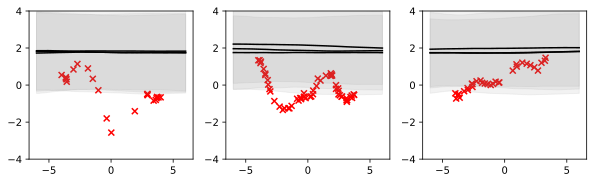

INFO:tensorflow:Assets written to: model-checkpoints/np/2020-11-13--17-20-22/000100.ckpt/assets


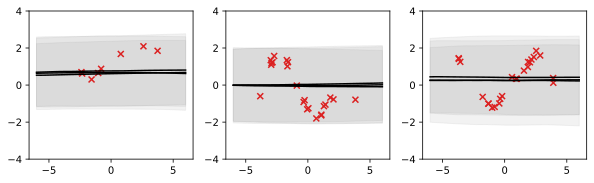

INFO:tensorflow:Assets written to: model-checkpoints/np/2020-11-13--17-20-22/000200.ckpt/assets


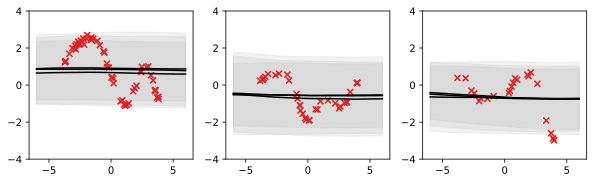

In [ ]:
input_dim = 1
output_dim = 1
rep_dim = 128
enc_hidden_dims = [128, 128]
dec_hidden_dims = [128, 128, 128, 128]
nonlinearity = 'relu'

encoder_ffn = FeedforwardNetwork(input_dim=(input_dim + output_dim),
                                 output_dim=2*rep_dim,
                                 hidden_dims=enc_hidden_dims,
                                 nonlinearity=nonlinearity)

decoder_ffn = FeedforwardNetwork(input_dim=(input_dim + rep_dim),
                                 output_dim=2*output_dim,
                                 hidden_dims=dec_hidden_dims,
                                 nonlinearity=nonlinearity)

encoder_latent_dist = GaussianLikelihood(reparam_func='sigmoid',
                                         single_noise_param=False)

decoder_likelihood = GaussianLikelihood(reparam_func='exp',
                                        single_noise_param=False)

encoder = NeuralNetworkEncoder(feedforward_network=encoder_ffn,
                               latent_dist=encoder_latent_dist)

decoder = NeuralNetworkDecoder(feedforward_network=decoder_ffn,
                               likelihood=decoder_likelihood)

neural_process = NeuralProcess(encoder=encoder, decoder=decoder)


learning_rate = 1e-3
num_steps = int(1e5)

optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate)    

x_min = -4.
x_max = 4.
num_datasets = 64
num_datapoints = 32
scale = 1e0
cov_coeff = 1e0
noise_coeff = 1e-2

current_time = datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
train_log_dir = f'logs/{current_time}/train'
train_writer = tf.summary.create_file_writer(train_log_dir)

for i in range(num_steps):

    x, y = sample_1d_datasets_from_gp(x_min=x_min,
                                      x_max=x_max,
                                      num_datasets=num_datasets,
                                      num_datapoints=num_datasets,
                                      scale=scale,
                                      cov_coeff=cov_coeff,
                                      noise_coeff=noise_coeff)

    x, y = tf.cast(x[..., None], dtype=tf.float32), tf.cast(y[..., None], dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        
        loss, loglik, kl_div = neural_process.loss_with_context(x, y, num_dataset_samples=1, num_latent_samples=1)
    
    gradients = tape.gradient(loss, neural_process.trainable_variables)
    optimiser.apply_gradients(zip(gradients, neural_process.trainable_variables))
    
    with train_writer.as_default():
        tf.summary.scalar('ELBO', -loss, step=i)
        tf.summary.scalar('Log Likelihood', loglik, step=i)
        tf.summary.scalar('KL divergence', kl_div, step=i)
        
    if i % 100 == 0: 
            
        tf.saved_model.save(neural_process, f'model-checkpoints/np/{current_time}/{i:06d}.ckpt')

        plt.figure(figsize=(10, 6))

        for i in range(3):

            xlin = tf.linspace(-6., 6., 100)[None, :, None]
            n = np.random.choice(np.arange(1, x.shape[1], 1))
            
            plt.subplot(2, 3, i+1)
            plt.scatter(x[i, :n, 0], y[i, :n, 0], marker='x', color='red')
            
            for k in range(3):
            
                pred_dist  = neural_process(x[i:i+1, :n, :], y[i:i+1, :n, :], xlin)

                mean = pred_dist.loc
                stdev = pred_dist.scale

                x_plot = np.array(xlin)[0, :, 0]
                mean = np.array(mean)[0, :, 0]
                stdev = np.array(stdev)[0, :, 0]

                plt.plot(x_plot, mean, color='black')
                plt.fill_between(x_plot, mean - 2 * stdev, mean + 2 * stdev, color='gray', alpha=0.1)
                
            plt.ylim([-4, 4])

        plt.show()